In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("felipekitamura/spr-x-ray-age-and-gender-dataset")

# print("Path to dataset files:", path)

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
dir = '/root/.cache/kagglehub/datasets/felipekitamura/spr-x-ray-age-and-gender-dataset/versions/1'

df_age = pd.read_csv(dir+'/train_age.csv')
df_gen = pd.read_csv(dir+'/train_gender.csv')

print(df_age.head())
print(df_gen.head())



   imageId   age
0        0  89.0
1        1  72.0
2        2  25.0
3        3  68.0
4        4  37.0
   imageId  gender
0        0       0
1        1       0
2        2       1
3        3       1
4        4       0


In [ ]:
im=[]
for i in tqdm(sorted(os.listdir(dir+'/kaggle/kaggle/train/'))):
    img = cv2.imread(dir+'/kaggle/kaggle/train/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255-img # creating the negative of the image
    img = cv2.resize(img,(128, 128))
    im.append(img)
    #img.append(plt.imread(dir+'kaggle/kaggle/train/'+i))
age = df_age['age']
gen= df_gen['gender']
data ={'Image': im,'Age':age,'Gender':gen}


100%|██████████| 10702/10702 [04:52<00:00, 36.64it/s]


In [60]:
df = pd.DataFrame(data)

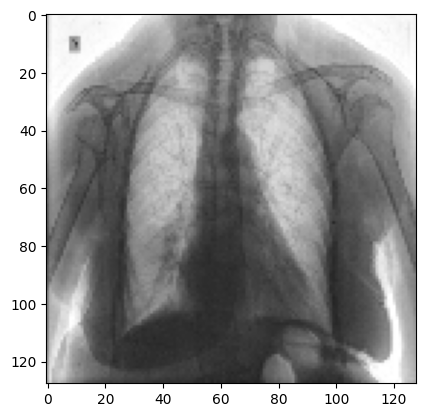

In [61]:
plt.imshow(cv2.cvtColor(df['Image'].iloc[0], cv2.COLOR_BGR2RGB))

In [62]:
X = np.array(data['Image'])
y = np.array(data['Gender'])

X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
y = y.reshape(-1,1)
X = X/255
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702, 1)


In [63]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization

In [64]:
def blockc(y,filt,kern):
    x = tensorflow.keras.layers.Conv2D(filt,kern, padding = 'same')(y)
    x = tensorflow.keras.layers.MaxPool2D(2 , strides = 2, padding = 'same')(x)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [65]:
#define model
tensorflow.keras.backend.clear_session()
model_gender = tensorflow.keras.Sequential()


inp = tensorflow.keras.layers.Input((128, 128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
out = tensorflow.keras.layers.Dense(1,activation='sigmoid')(c6)
model_gender = tensorflow.keras.Model(inputs = [inp], outputs = [out])


In [66]:
model_gender.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
model_gender.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 191,257 (747.10 KB)

 Trainable params: 190,585 (744.47 KB)

 Non-trainable params: 672 (2.62 KB)

In [68]:
history = model_gender.fit(
    X,y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs = 5
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


 952/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7355 - loss: 0.5142

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7386 - loss: 0.5102 - val_accuracy: 0.7702 - val_loss: 0.5190
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8831 - loss: 0.2945 - val_accuracy: 0.7655 - val_loss: 0.5305
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9071 - loss: 0.2447 - val_accuracy: 0.9290 - val_loss: 0.1801
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9346 - loss: 0.1835 - val_accuracy: 0.9416 - val_loss: 0.1546
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9420 - loss: 0.1709 - val_accuracy: 0.9514 - val_loss: 0.1439


<Axes: >

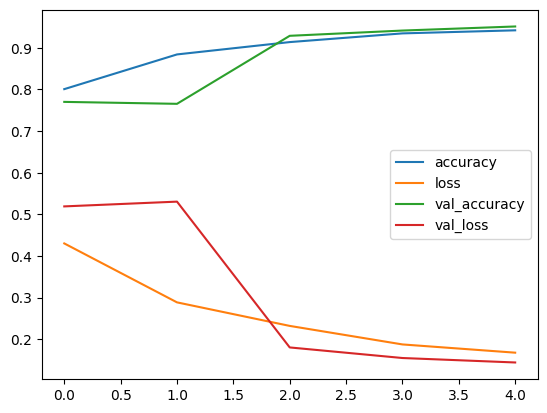

In [69]:
pd.DataFrame(history.history).plot()

In [70]:
model_gender.save('model_gender.h5')

### age pedication


In [71]:
y = np.array(data['Age'])
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702,)


In [72]:
tensorflow.keras.backend.clear_session()
model_age = tensorflow.keras.Sequential()


inp = tensorflow.keras.layers.Input((128, 128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
c7 = tensorflow.keras.layers.Flatten()(c6)
c8 = tensorflow.keras.layers.Dense(100,activation='linear')(c7)
c9 = tensorflow.keras.layers.Dense(50,activation='linear')(c8)
out = tensorflow.keras.layers.Dense(1,activation='linear')(c9)
model_age = tensorflow.keras.Model(inputs = [inp], outputs = [out])


In [ ]:
model_age.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model_age.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 199,625 (779.79 KB)

 Trainable params: 198,953 (777.16 KB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:
history = model_age.fit(
    X,y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs = 10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


 952/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 643.8218 - mse: 643.8218

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 629.5457 - mse: 629.5457 - val_loss: 161.7481 - val_mse: 161.7481
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 192.7008 - mse: 192.7008 - val_loss: 175.0220 - val_mse: 175.0220
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 147.0163 - mse: 147.0163 - val_loss: 110.5752 - val_mse: 110.5752
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 133.5162 - mse: 133.5162 - val_loss: 112.8175 - val_mse: 112.8175
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 118.2619 - mse: 118.2619 - val_loss: 105.5146 - val_mse: 105.5146
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 109.2346 - mse: 109.2346 - val_loss: 178.6394 - val_mse: 178.6394
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 100.9234 - mse: 100.9234 - val_loss: 86.4399 - val_mse: 86.4399
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 95.5634 - mse: 95.5634 - val_loss: 135.5134 - val_mse

<Axes: >

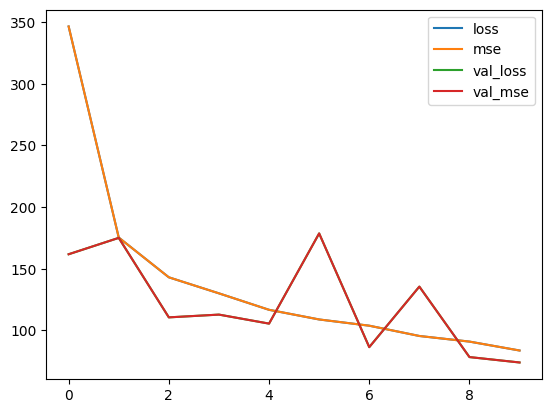

In [ ]:
pd.DataFrame(history.history).plot()

In [75]:
model_age.save('model_age.h5')

In [73]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = model_gender.predict(X)
pred = []
for i in tqdm(y_pred):
    if i<0.5:
        pred.append(0)
    else:
        pred.append(1)
pred = np.array(pred)

print(pred.shape,y.shape)
print(pred[5:15],gen[5:15])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)


332/335 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


100%|██████████| 10702/10702 [00:00<00:00, 759683.88it/s]

(10702,) (10702,)
[1 1 0 0 1 1 0 1 0 1] 5     1
6     1
7     1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
Name: gender, dtype: int64


In [74]:
pred = np.round(model_age.predict(X))
print(pred[5:15],age[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]] 5     62.0
6     52.0
7     46.0
8     83.0
9     33.0
10    82.0
11    78.0
12    61.0
13    74.0
14    28.0
Name: age, dtype: float64


In [76]:
import sys
print(sys.version)


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
